# Gaussian mixture models for phase fitting

Reads exported data from flow cytometry analysis folder (in which cells were stained with DNA-binding dye such as Propidium Iodide). Fits a combination of three gaussians (representing G0/1, S, G2/M phases) to the fluorescence histogram, then uses the generated model to classify cells in each phase.

Individual models could alternatively be used to predict cell phase from multiple samples (i.e. in the case of a control vs treated style experimental design).

In [5]:
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from loguru import logger
from matplotlib import rc
from pandas_profiling import ProfileReport
from sklearn import mixture
from sklearn.mixture import GaussianMixture
from GEN_Utils import FileHandling
logger.info('Import OK')

2019-08-04 17:24:02.298 | INFO     | __main__:<module>:15 - Import OK


In [13]:
### Define some useful functions

In [6]:
def preprocess(df, cell_col, upper_thresh=15000, lower_thresh=2500):
    # Upper and lower thresholds remove apoptotic and multiploidal cells
    #cell_col =fluorescence channel name in which cell phases will be fitted
    if lower_thresh:
        df = df[df[cell_col] > lower_thresh]
        logger.info(f'Lower threshold of {lower_thresh} applied.')
    if upper_thresh:
        df = df[df[cell_col] < upper_thresh]
        logger.info(f'Upper threshold of {upper_thresh} applied.')
    # Normalise data to maximum value (theoretically is likely to be equivalent to the upper_thresh)
    df[cell_col] = df[cell_col]/upper_thresh
    return df

def file_processor(input_path, cell_col, upper_thresh=2600, lower_thresh=500):
    sample_dict = {}
    raw_data = pd.read_csv(input_path)
    # sns.distplot(raw_data, bins=1000, hist=True, kde=True, rug=False, fit=None, hist_kws=None, kde_kws=None, rug_kws=None, fit_kws=None, color=None, vertical=False, norm_hist=False, axlabel=None, label=None, ax=None)
    # plt.show()
    logger.debug('Raw data successfully loaded')
    sample_dict['raw_data'] = raw_data.copy()
    sample_dict['normalised'] = preprocess(
        raw_data, upper_thresh=upper_thresh, lower_thresh=lower_thresh, cell_col=cell_col)
    logger.debug(f'{sample_name} normalised.')
    return sample_dict

def model_fitter(x_array, num_components=3):
    # Fit initial data, including preprocessing to generate array
    ravelled = np.ravel(x_array).astype(np.float)
    shaped = ravelled.reshape(-1, 1)
    # establish model
    gauss_model = mixture.GaussianMixture(
        n_components=num_components, covariance_type='full')
    gauss_model.fit(shaped)
    return gauss_model

def model_plotter(model, x_vals, sample_name=None):
    #collect weights etc
    weights = gauss_model.weights_
    means = gauss_model.means_
    covars = gauss_model.covariances_
    # Plot individual fits
    palette = iter(sns.color_palette(n_colors=len(covars)))
    x_vals.sort()
    fig = plt.subplots()
    sns.distplot(x_vals, bins=100, color='crimson')  # original data
    # plot normal distribution for x_values
    for x in range(0, len(weights)):
        plt.plot(x_vals, weights[x]*stats.norm.pdf(x_vals,
                                                   means[x], np.sqrt(covars[x])).ravel(), color=next(palette), label=f'Cluster {x}')
    plt.legend()
    plt.title(sample_name)
    plt.xlabel('Normalised PI Fluorescence (A.U.)')
    plt.ylabel('Density')
    plt.grid()
    return fig



In [7]:
input_folder = 'test_data/flow_cytometry/'

output_folder = 'examples/python/gauss_models/'
# Column name containing PI fluorescence information

cell_col = 'PI'
output_folder_list = [output_folder] + [f'{output_folder}plots/', f'{output_folder}normalised/']

for folder in output_folder_list:
    if not os.path.exists(folder):
        os.mkdir(folder)

### Check raw data

In [8]:
filelist = [filename for filename in os.listdir(input_folder)]

for filename in filelist[:3]:
    input_path = input_folder + filename
    filename, file_extension = os.path.splitext(filename)
    sample_name = filename.split('_')[1]
    # Check raw data
    raw_data = pd.read_csv(input_path)
    ProfileReport(raw_data)

In [9]:
ProfileReport(raw_data)

Text(0.5, 1, '1A3')

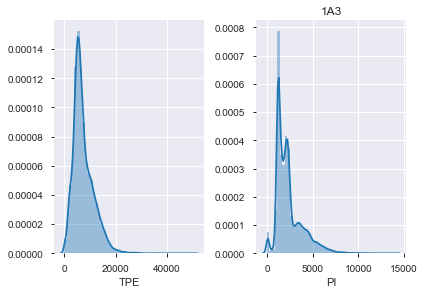

In [10]:
fig, axes = plt.subplots(1, len(raw_data.columns.tolist()))

for x, col in enumerate(raw_data.columns.tolist()):
    sns.distplot(raw_data[col], ax=axes[x])

plt.tight_layout()
plt.autoscale()
plt.title(sample_name)

2019-08-04 17:25:19.547 | DEBUG    | __main__:file_processor:19 - Raw data successfully loaded
2019-08-04 17:25:19.550 | INFO     | __main__:preprocess:6 - Lower threshold of 500 applied.
2019-08-04 17:25:19.551 | INFO     | __main__:preprocess:9 - Upper threshold of 2600 applied.
2019-08-04 17:25:19.553 | DEBUG    | __main__:file_processor:23 - 1A1 normalised.
2019-08-04 17:25:19.554 | INFO     | __main__:<module>:13 - 1A1 was not processed.
2019-08-04 17:25:19.569 | DEBUG    | __main__:file_processor:19 - Raw data successfully loaded
2019-08-04 17:25:19.572 | INFO     | __main__:preprocess:6 - Lower threshold of 500 applied.
2019-08-04 17:25:19.575 | INFO     | __main__:preprocess:9 - Upper threshold of 2600 applied.
2019-08-04 17:25:19.576 | DEBUG    | __main__:file_processor:23 - 1A2 normalised.
2019-08-04 17:25:20.345 | DEBUG    | __main__:file_processor:19 - Raw data successfully loaded
2019-08-04 17:25:20.348 | INFO     | __main__:preprocess:6 - Lower threshold of 500 applied.
2

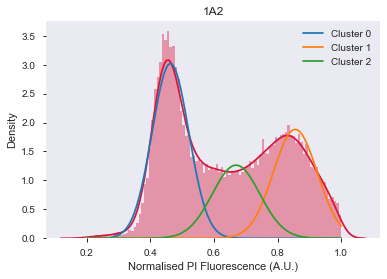

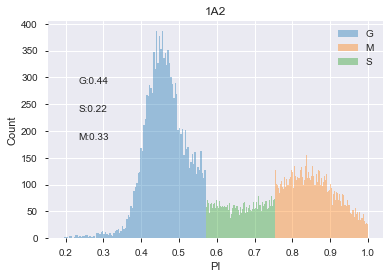

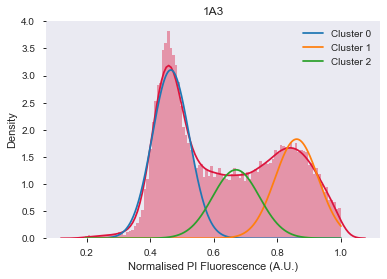

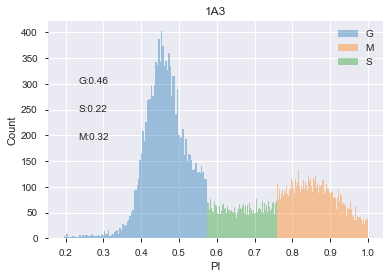

In [11]:
data_dict = {}
filelist = [filename for filename in os.listdir(input_folder)]

for filename in filelist[:3]:
    input_path = input_folder + filename
    filename, file_extension = os.path.splitext(filename)
    sample_name = filename.split('_')[1]
    sample_dict = file_processor(input_path, cell_col, upper_thresh=2600, lower_thresh=500)
    # Generate array of PI normalised values, fit to GMM and plot
    x_array = np.array(sample_dict['normalised'][cell_col])
    # As a general rule, no point fitting datasets of > 1000 cells (either controls or real)
    if x_array.shape[0] < 1000:
        logger.info(f'{sample_name} was not processed.')
        continue
    gauss_model = model_fitter(x_array)
    fig = model_plotter(gauss_model, x_array.ravel(), sample_name=sample_name)
    plt.savefig(f"{output_folder}plots/{sample_name}_model.png")
    # Use fitted GMM to predict the cluster for each cell, add to normalised df
    sample_dict['normalised']['cluster'] = gauss_model.predict(
        np.array(sample_dict['normalised'][cell_col]).reshape(-1, 1))
    # Determine which cluster maps to which phase according to mean values
    cluster_allocations = pd.DataFrame()
    cluster_allocations['names'] = [0, 1, 2]
    cluster_allocations['means'] = gauss_model.means_
    cluster_allocations = cluster_allocations.sort_values('means')
    cluster_allocations['phase'] = ['G', 'S', 'M']
    phase_dict = dict(
        zip(cluster_allocations['names'], cluster_allocations['phase']))
    # Assign phase names to df
    sample_dict['normalised']['phase'] = sample_dict['normalised']['cluster'].map(
        phase_dict)
    # Calculate proportion in each cluster, assign to dictionary
    sample_dict['proportions'] = dict(
        sample_dict['normalised']['phase'].value_counts() / len(sample_dict['normalised']))
    # Plot histogram showing binned dataset
    phase_pos = [0.7, 0.6, 0.5]
    fig = plt.subplots()
    for groupname, groupdata in sample_dict['normalised'].groupby('phase'):
        sns.distplot(groupdata[cell_col], bins=100,
                     kde=False, norm_hist=False, label=groupname)
    for x, phase in enumerate(['G', 'S', 'M']):
        proportion = round(sample_dict['proportions'][phase], 2)
        plt.annotate(f'{phase}:{proportion}',
                     (0.2, phase_pos[x]), xycoords='figure fraction')
    plt.legend()
    plt.title(sample_name)
    plt.ylabel('Count')
    plt.savefig(f'{output_folder}plots/{sample_name}_predict.png')
    data_dict[sample_name] = sample_dict

### Save cluster-labelled df to csvs

In [12]:
for sample in data_dict.keys():
    data = data_dict[sample]['normalised']
    data.to_csv(f"{output_folder}normalised/{sample}.csv")

### Collect proportions into simple df labelled with sample name

In [17]:
summary = pd.DataFrame(index=data_dict.keys(), columns=['G', 'S', 'M'])

for sample in data_dict.keys():
    proportions = data_dict[sample]['proportions']
    summary.loc[sample, 'G'] = proportions['G']
    summary.loc[sample, 'S'] = proportions['S']
    summary.loc[sample, 'M'] = proportions['M']

summary.rename_axis('sample', inplace=True)
summary.reset_index(inplace=True)

In [18]:
summary.head(10)

,sample,G,S,M
0,1A2,0.443085,0.224768,0.332147
1,1A3,0.457413,0.220534,0.322053
